0. 1장 요약
1. 전처리
    1. 한국어 위키백과
    2. KorQuAD
    3. 네이버 리뷰 영화 말뭉치
2. 형태소 분석기 
    1. konlpy 
    2. khaiii
    3. 사전 추가 방법

# 1장 요약
프리트레인 - 파인튜닝

- 프리트레인 : 임베딩
    - 행렬 분해 방법 : GloVe, Swivel
    - 예측 기반 방법 : Word2Vec, FastText, BERT, ELMo, GPT
    - 토픽 기반 방법 : LDA (각 문서의 주제 분포를 확률 벡터 형태로도 확인 할 수 있어, 임베딩의 일종으로 볼 수 있음)
- 임베딩을 입력으로 하는 새로운 딥러닝 모델
- 파인 튜닝 : 풀고자하는 문제에 맞는 소규모 데이터로 임베딩을 포함한 (딥러닝) 모델 전체를 업데이트, ELMo, GPT, BERT

# 1. 전처리

## 1.1. 한국어 위키백과
- 방대한 데이터, 위키백과중 24번째로 큼
- 집단 지성의 사례

### 다운로드

In [12]:
! ../preprocess.sh dump-raw-wiki
# ! wget https://dumps.wikimedia.org/kowiki/latest/kowiki-latest-pages-articles.xml.bz2 -P /notebooks/embedding/data/raw
# 666 MB

download ko-wikipedia...
--2020-07-31 01:45:54--  https://dumps.wikimedia.org/kowiki/latest/kowiki-latest-pages-articles.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
접속 dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 697692427 (665M) [application/octet-stream]
Saving to: ‘/notebooks/embedding/data/raw/kowiki-latest-pages-articles.xml.bz2.1’

kowiki-latest-pages 100%[===================>] 665.37M  1.29MB/s    in 5m 37s  

2020-07-31 01:51:32 (1.98 MB/s) - ‘/notebooks/embedding/data/raw/kowiki-latest-pages-articles.xml.bz2.1’ saved [697692427/697692427]



### 전처리

- gensim의 WikiCorpus를 통해 다운로드 받은 wiki 데이터를 읽는다.
- 토크나이징 추가 규칙(tokenize)을 코딩하여, 인자로 전달한다.

In [7]:
import re, json, glob, argparse
from gensim.corpora import WikiCorpus, Dictionary
from gensim.utils import to_unicode

WIKI_REMOVE_CHARS = re.compile("'+|(=+.{2,30}=+)|__TOC__|(ファイル:).+|:(en|de|it|fr|es|kr|zh|no|fi):|\n", re.UNICODE)
WIKI_SPACE_CHARS = re.compile("(\\s|゙|゚|　)+", re.UNICODE)
EMAIL_PATTERN = re.compile("(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", re.UNICODE)
URL_PATTERN = re.compile("(ftp|http|https)?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", re.UNICODE)
WIKI_REMOVE_TOKEN_CHARS = re.compile("(\\*$|:$|^파일:.+|^;)", re.UNICODE)
MULTIPLE_SPACES = re.compile(' +', re.UNICODE)


def tokenize(content, token_min_len=2, token_max_len=100, lower=True):
    content = re.sub(EMAIL_PATTERN, ' ', content)  # remove email pattern
    content = re.sub(URL_PATTERN, ' ', content) # remove url pattern
    content = re.sub(WIKI_REMOVE_CHARS, ' ', content)  # remove unnecessary chars
    content = re.sub(WIKI_SPACE_CHARS, ' ', content)
    content = re.sub(MULTIPLE_SPACES, ' ', content)
    tokens = content.replace(", )", "").split(" ")
    result = []
    for token in tokens:
        if not token.startswith('_'):
            token_candidate = to_unicode(re.sub(WIKI_REMOVE_TOKEN_CHARS, '', token))
        else:
            token_candidate = ""
        if len(token_candidate) > 0:
            result.append(token_candidate)
    return result

def make_corpus(in_f, out_f):
    """Convert Wikipedia xml dump file to text corpus"""
    output = open(out_f, 'w', encoding = "utf-8")
    wiki = WikiCorpus(in_f, tokenizer_func=tokenize, dictionary=Dictionary())
    i = 0
    for text in wiki.get_texts():
        output.write(bytes(' '.join(text), 'utf-8').decode('utf-8') + '\n')
        i = i + 1
        if (i % 10000 == 0):
            print('Processed ' + str(i) + ' articles')
    output.close()
    print('Processing complete!')

In [8]:
in_f = "/notebooks/embedding/data/raw/kowiki-latest-pages-articles.xml.bz2"
out_f = "/notebooks/embedding/data/processed/processed_wiki_ko2.txt"
make_corpus(in_f, out_f)

Processed 10000 articles
Processed 20000 articles
Processed 30000 articles
Processed 40000 articles
Processed 50000 articles
Processed 60000 articles
Processed 70000 articles
Processed 80000 articles
Processed 90000 articles
Processed 100000 articles
Processed 110000 articles
Processed 120000 articles
Processed 130000 articles
Processed 140000 articles
Processed 150000 articles
Processed 160000 articles
Processed 170000 articles
Processed 180000 articles
Processed 190000 articles
Processed 200000 articles
Processed 210000 articles
Processed 220000 articles
Processed 230000 articles
Processed 240000 articles
Processed 250000 articles
Processed 260000 articles
Processed 270000 articles
Processed 280000 articles
Processed 290000 articles
Processed 300000 articles
Processed 310000 articles
Processed 320000 articles
Processed 330000 articles
Processed 340000 articles
Processed 350000 articles
Processing complete!


In [9]:
with open(out_f) as f:
    for i, line in enumerate(f):
        print(line)
        if i > 10:
            break

제임스 얼 "지미" 카터 주니어 (, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령 (1977년 ~ 1981년)이다. 지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다. 1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다. 취임식을 올리는 카터 1976년 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워, 포드를 누르고 당선되었다. 카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다. Carter Begin, Camp David 1978.gif|섬네일|300px|캠프데이비드에서 사다트와 베긴과 함께카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다. 그러나 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. 1979년 백악관에서 양국 간의 평화조약으로 이끌어졌다. 또한 소련과 제2차 전략 무기 제한 협상에 조인했다. 카터는 1970년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다. 그러나 주 이란 미국 대사관 인질 사건에서 인질 구출 실패를 이유로 1980년 대통령 선거에서 공화당의 로널드 레이건 후보에게 져 결국 재선에 실패했다. 또한 임기 말기에 터진 소련의 아프가니스탄 침공 사건으

## 1.2. KorQuAD

- 한국어 위키백과의 '알찬 글', '좋은 글'등 양질의 문서를 수집해 이 가운데 일부 문단으로부터 파생될 수 있는 질문과 답변 쌍을 사람들이 직접 만듬
- 여기서는 korquad v1.0
    - 1,560 개의 Wikipedia article에 대해 10,645 건의 문단과 66,181 개의 질의응답 쌍
    - Training set 60,407 개, Dev set 5,774 개의 질의응답쌍
- korquad v2.0은 데이터가 훨씬 많음
- 소개 : https://www.slideshare.net/SeungyoungLim/korquad-introduction
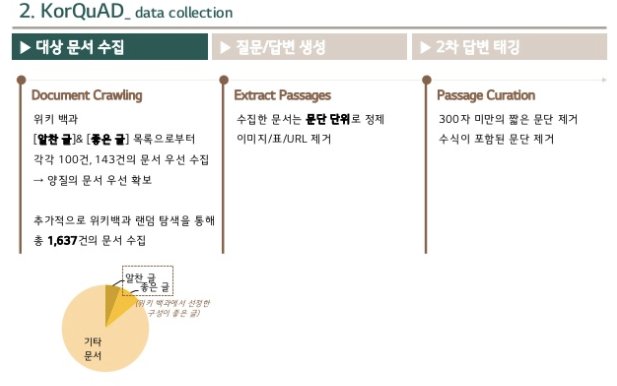

### 다운로드

In [13]:
! ../preprocess.sh dump-raw-korquad
# ! wget https://korquad.github.io/dataset/KorQuAD_v1.0_train.json -P /notebooks/embedding/data/raw
# ! wget https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json -P /notebooks/embedding/data/raw

download KorQuAD data...
--2020-07-31 01:51:33--  https://korquad.github.io/dataset/KorQuAD_v1.0_train.json
Resolving korquad.github.io (korquad.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
접속 korquad.github.io (korquad.github.io)|185.199.111.153|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 38527475 (37M) [application/json]
Saving to: ‘/notebooks/embedding/data/raw/KorQuAD_v1.0_train.json’

KorQuAD_v1.0_train. 100%[===================>]  36.74M  4.15MB/s    in 9.2s    

2020-07-31 01:51:43 (3.97 MB/s) - ‘/notebooks/embedding/data/raw/KorQuAD_v1.0_train.json’ saved [38527475/38527475]

--2020-07-31 01:51:43--  https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json
Resolving korquad.github.io (korquad.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
접속 korquad.github.io (korquad.github.io)|185.199.111.153|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 3881058 (3.7M) [application/json]
Saving to: ‘/no

In [22]:
import json
with open("/notebooks/embedding/data/raw/KorQuAD_v1.0_train.json") as f:
    sample = json.load(f)
sample['data'][0]

{'paragraphs': [{'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
   'qas': [{'answers': [{'answer_start': 54, 'text': '교향곡'}],
     'id': '6566495-0-0',
     'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'},
    {'answers': [{'answer_start': 421, 'text': '1악장'}],
     'id': '6566495-0-1',
     'question': '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?'},
    {'answers': [{'ans

### 전처리

문단(paragraph)별로 내용, 질문들, 답변들을 추출

In [15]:
def process_korQuAD(corpus_fname, output_fname):
    with open(corpus_fname) as f1, open(output_fname, 'w', encoding='utf-8') as f2:
        dataset_json = json.load(f1)
        dataset = dataset_json['data']
        for article in dataset:
            w_lines = []
            for paragraph in article['paragraphs']:
                w_lines.append(paragraph['context'])
                for qa in paragraph['qas']:
                    q_text = qa['question']
                    for a in qa['answers']:
                        a_text = a['text']
                        w_lines.append(q_text + " " + a_text)
            for line in w_lines:
                f2.writelines(line + "\n")

In [16]:
in_f = "/notebooks/embedding/data/raw/KorQuAD_v1.0_train.json"
out_f = "/notebooks/embedding/data/processed/processed_korquad_train.txt"
process_korQuAD(in_f, out_f)

In [17]:
with open(out_f) as f:
    for i, line in enumerate(f):
        print(line)
        if i > 10:
            break

1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.

바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가? 교향곡

바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가? 1악장

바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가? 베토벤의 교향곡 9번

1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은? 파우스트

파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은? 합창교향곡

바그너가 파우스트를 처음으로 읽은 년도는? 1839

바그너가 처음 교향곡 작곡을 한 장소는? 파리

바그너의 1악장의 초연은 어디서 연주되었는가? 드레스덴

한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부

## 1.3. 네이버 영화 리뷰 말뭉치
- 네이버 영화 페이지의 영화 리뷰들을 평점과 함께 수록한 한국어 말뭉치.
- tsv 포맷으로 레코드 하나가 문서(리뷰)에 해당하며,  문서 id, 문서 내용, 레이블(긍정 1, 부정 0)컬럼으로 구성
- 데이터 크기는 20만개이며 긍정:부정 = 1:1 비율

### 다운로드

In [23]:
! ../preprocess.sh dump-raw-nsmc
# ! wget https://github.com/e9t/nsmc/raw/master/ratings.txt -P /notebooks/embedding/data/raw
# ! wget https://github.com/e9t/nsmc/raw/master/ratings_train.txt -P /notebooks/embedding/data/raw
# ! wget https://github.com/e9t/nsmc/raw/master/ratings_test.txt -P /notebooks/embedding/data/raw

download naver movie corpus...
--2020-07-31 02:25:25--  https://github.com/e9t/nsmc/raw/master/ratings.txt
Resolving github.com (github.com)... 52.78.231.108
접속 github.com (github.com)|52.78.231.108|:443... 접속됨.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt [following]
--2020-07-31 02:25:25--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.228.133
접속 raw.githubusercontent.com (raw.githubusercontent.com)|151.101.228.133|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 19515078 (19M) [text/plain]
Saving to: ‘/notebooks/embedding/data/raw/ratings.txt’

ratings.txt         100%[===================>]  18.61M  7.69MB/s    in 2.4s    

2020-07-31 02:25:28 (7.69 MB/s) - ‘/notebooks/embedding/data/raw/ratings.txt’ saved [19515078/19515078]

--2020-07-31 02:25:28--  https://github.com/e9t/nsmc/raw/master/ratings_t

In [28]:
with open("/notebooks/embedding/data/raw/ratings_train.txt") as f:
    for _ in range(10):
        print(f.readline())

id	document	label

9976970	아 더빙.. 진짜 짜증나네요 목소리	0

3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1

10265843	너무재밓었다그래서보는것을추천한다	0

9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0

6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1

5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0

7797314	원작의 긴장감을 제대로 살려내지못했다.	0

9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0

7156791	액션이 없는데도 재미 있는 몇안되는 영화	1



### 전처리
- tsv 포맷, 탭(\t)으로 스플릿.
- 라벨 포함 가능

In [34]:
def process_nsmc(corpus_path, output_fname, process_json=True, with_label=True):
    if process_json:
        file_paths = glob.glob(corpus_path + "/*")
        with open(output_fname, 'w', encoding='utf-8') as f:
            for path in file_paths:
                contents = json.load(open(path))
                for content in contents:
                    sentence = content['review'].strip()
                    if len(sentence) > 0:
                        f.writelines(sentence + "\u241E" + content['movie_id'] + "\n")
    else:
        with open(corpus_path, 'r', encoding='utf-8') as f1, \
                open(output_fname, 'w', encoding='utf-8') as f2:
            next(f1)  # skip head line
            for line in f1:
                _, sentence, label = line.strip().split('\t')
                if not sentence: continue
                if with_label:
                    f2.writelines(sentence + "\u241E" + label + "\n")
                else:
                    f2.writelines(sentence + "\n")
    
in_f = "/notebooks/embedding/data/raw/ratings_train.txt"
out_f = "/notebooks/embedding/data/processed/processed_ratings.txt"
process_nsmc(in_f, out_f, process_json=False, with_label=True)

In [35]:
with open("/notebooks/embedding/data/processed/processed_ratings.txt") as f:
    for _ in range(10):
        print(f.readline())

아 더빙.. 진짜 짜증나네요 목소리␞0

흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나␞1

너무재밓었다그래서보는것을추천한다␞0

교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정␞0

사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다␞1

막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.␞0

원작의 긴장감을 제대로 살려내지못했다.␞0

별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네␞0

액션이 없는데도 재미 있는 몇안되는 영화␞1

왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?␞1



# 2. 형태소 분석기 (지도기반)

- 어휘 집합(중복 없는 단어 사전)이 많으면 연산의 비효율 발생
- 가다 -> 가겠다, 가더라, 가겠더라, 가다
    - 가겠다 > 가, 겠, 다
    - 가더라 > 가, 더라
    - {가, 겠, 다, 더라} -> " 가겠다, 가더라, 가겠더라, 가다 "를 커버

## 2.1. Konlpy

- 여러 언어로 짜여진 형태소 분석 라이브러리를 python 인터페이스로 통합

|  <center>이름</center> |  <center>알고리즘</center> |  <center>개발 언어</center> | <center>git</center> |
|:--------|:--------:|--------:|--------:|
|Kkma | |Java | https://github.com/konlpy/kkma|
|Komoran |HMM|Java|https://github.com/shineware/KOMORAN|
|Hannanum |HMM|Java|https://github.com/haven-jeon/HanNanum-Analyzer|
|Okt(Twitter) ||Scala/Java|https://github.com/open-korean-text/open-korean-text|
|Mecab |CRF|C/C++|https://github.com/hephaex/mecab-ko|
|Khaiii |CNN|Python/C++|https://github.com/kakao/khaiii|

### 전처리
- 코로나 19 관련 신조어
    - https://sesang-story.tistory.com/560
    - 신조어는 미등록 단어 중 하나

In [1]:
in_f = "/notebooks/embedding/data/raw/covid.txt"
out_f = "/notebooks/embedding/data/processed/processed_covid.txt"
with open(in_f) as r, open(out_f, 'w') as w:
    contents = []
    for line in r:
        line = line.strip()
        contents.append(line) if line else []
    tmp = ''
    for i, c in enumerate(contents):
        tmp += c + ' '
        if i%2!=0:
            w.write(tmp + '\n')
            tmp = ''
with open(out_f) as f:
    for _ in range(10):
        print(f.readline())

코로나 블루 코로나 19와 우울감(blue)이 합쳐진 신조어, 코로나 19 확산으로 일상에 큰 변화가 닥치면서 생긴 우울감이나 무기력증을 뜻한다. 즉, 코로나 19 사태가 장기화되면서 사람들이 자신도 언제 감염될지 모른다는 두려움을 느끼고, 무기력과 불안에 시달리는 감정을 의미한다. 

코비디어트 코로나 19의 영어 명칭인 Covid-19의 코비드와 Idiot(바보)를 합친 말로, 코로나 19가 확산되는 상황에서 자가격리 수칙을 어기거나 마스크 착용을 하지 않는 행동 등으로 타인에게 해를 끼치는 사람들을 가리킨다. 

코로노미 쇼크 코로나와 이코노미 (economy)의 합성어로, 코로나 19로 인한 경제적 타격을 의미한다. 코로나 19가 장기화되면서 전 세계적으로 기 업들의 매출 급감, 실업대란, 취약계층들의 생활고가 가중되는 등 경제 위기가 이어지고 있다. 이에 우리나라를 비롯 전 세계 많은 국가들이 국민들에게 일정 금액의 돈을 지급하는 현금지원 대책을 내놓고 있다. 

언택트(Untact) 부정 접두사인 Un과 접촉을 뜻하는 Contact를 합친 말로 비대면, 비접촉 방식이 일상이 돼버린 요즘을 가리키는 신조어이다. 즉, 업무는 온라인으로 처리하고 식사는 온라인 쇼핑몰을 이용하거나 배달업체 등을 이용하는 것이다. 파생어로 재택 경제, 집관, 집콕족 등이 있다. 우리 회사도 지난달 23일 MBKit에 PC선을 인도하면서 화상으로 인도 서명을 하였다. 

동학 개미 운동 코로나 19 확산 사태가 장기화되면서 주식 시장에서 등장한 신조어로, 국내 개인투자자들이 기관과 외국인에 맞서 국내 주식을 대거 사들인 상황을 1893년 반외세 운동인 '동학농민운동'에 빗댄 표현이다. 

금스크 마스크 수요가 폭증하면서 생겨난 말이다. 마스크를 구하기 어려울뿐더러 그 가격도 높아 금처럼 귀하다는 의미로 사용되고 있다. 아울러 마스크 착용 시간이 길어지면서 마스크에 화장이 묻지 않는 메이크업을 의미하는 마스크 메이크업이라는 신조어도 등장했다. 

확찐자 대표적인 웃픈 신조어이다

### 태거 공통 함수
- 태그표 : https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0# 

In [12]:
from konlpy.tag import Mecab, Okt, Komoran, Hannanum, Kkma
print(Mecab.morphs.__doc__) # 형태로소 토크나이징한다.
print(Mecab.nouns.__doc__)  # 명사만 추출한다.
print(Mecab.pos.__doc__)    # 형태소와 태그를 출력한다.


Parse phrase to morphemes.
Noun extractor.
POS tagger.

        :param flatten: If False, preserves eojeols.
        :param join: If True, returns joined sets of morph and tag.
        


### 토크나이징
- 태깅 방식, 알고리즘에 따라 추출 품질이 다를것으로 보임

In [2]:
from konlpy.tag import Mecab, Okt, Komoran, Hannanum, Kkma

def get_tokenizer(name):
    if name.lower()=="mecab":
        return Mecab()
    elif name.lower()=="okt":
        return Okt()
    elif name.lower()=="komoran":
        return Komoran()
    elif name.lower()=="hannanum":
        return Hannanum()
    else:
        return Kkma()

name_list = ['mecab', 'okt', 'hannanum', 'kkma'] # 'komoran'
with open(out_f) as f:
    for _ in range(10):
        target = f.readline()
        print('context')
        print(target)
        for name in name_list:
            tokenizer = get_tokenizer(name)
            print()
            print(name)
            print()
            print(tokenizer.morphs(target))
            print()
            print(tokenizer.pos(target))
            print()
            print()

context
코로나 블루 코로나 19와 우울감(blue)이 합쳐진 신조어, 코로나 19 확산으로 일상에 큰 변화가 닥치면서 생긴 우울감이나 무기력증을 뜻한다. 즉, 코로나 19 사태가 장기화되면서 사람들이 자신도 언제 감염될지 모른다는 두려움을 느끼고, 무기력과 불안에 시달리는 감정을 의미한다. 


mecab

['코로나', '블루', '코로나', '19', '와', '우울', '감', '(', 'blue', ')', '이', '합쳐진', '신조어', ',', '코로나', '19', '확산', '으로', '일상', '에', '큰', '변화', '가', '닥치', '면서', '생긴', '우울', '감', '이나', '무기력증', '을', '뜻', '한다', '.', '즉', ',', '코로나', '19', '사태', '가', '장기', '화', '되', '면서', '사람', '들', '이', '자신', '도', '언제', '감염', '될지', '모른다는', '두려움', '을', '느끼', '고', ',', '무', '기력', '과', '불', '안', '에', '시달리', '는', '감정', '을', '의미', '한다', '.']

[('코로나', 'NNP'), ('블루', 'NNP'), ('코로나', 'NNP'), ('19', 'SN'), ('와', 'JC'), ('우울', 'NNG'), ('감', 'XSN'), ('(', 'SSO'), ('blue', 'SL'), (')', 'SSC'), ('이', 'JKS'), ('합쳐진', 'VV+EC+VX+ETM'), ('신조어', 'NNG'), (',', 'SC'), ('코로나', 'NNP'), ('19', 'SN'), ('확산', 'NNG'), ('으로', 'JKB'), ('일상', 'NNG'), ('에', 'JKB'), ('큰', 'VA+ETM'), ('변화', 'NNG'), ('가', 'JKS'), ('닥치', 'VV'), ('면서', 'EC'), ('생긴', 'VV+ETM'), ('우울', 'NNG'), (

/usr/local/lib/python3.5/dist-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)



okt

['코로나', '블루', '코로나', '19', '와', '우울', '감', '(', 'blue', ')', '이', '합쳐진', '신조어', ',', '코로나', '19', '확산', '으로', '일상', '에', '큰', '변화', '가', '닥치면서', '생긴', '우울', '감', '이나', '무기력증', '을', '뜻', '한다', '.', '즉', ',', '코로나', '19', '사태', '가', '장기', '화', '되면서', '사람', '들', '이', '자신', '도', '언제', '감염', '될지', '모른다는', '두려움', '을', '느끼고', ',', '무기', '력', '과', '불안', '에', '시달리는', '감정', '을', '의미', '한다', '.']

[('코로나', 'Noun'), ('블루', 'Noun'), ('코로나', 'Noun'), ('19', 'Number'), ('와', 'Verb'), ('우울', 'Noun'), ('감', 'Noun'), ('(', 'Punctuation'), ('blue', 'Alpha'), (')', 'Punctuation'), ('이', 'Noun'), ('합쳐진', 'Verb'), ('신조어', 'Noun'), (',', 'Punctuation'), ('코로나', 'Noun'), ('19', 'Number'), ('확산', 'Noun'), ('으로', 'Josa'), ('일상', 'Noun'), ('에', 'Josa'), ('큰', 'Verb'), ('변화', 'Noun'), ('가', 'Josa'), ('닥치면서', 'Verb'), ('생긴', 'Verb'), ('우울', 'Noun'), ('감', 'Noun'), ('이나', 'Josa'), ('무기력증', 'Noun'), ('을', 'Josa'), ('뜻', 'Noun'), ('한다', 'Verb'), ('.', 'Punctuation'), ('즉', 'Noun'), (',', 'Punctuation'), ('코로나',

java.lang.OutOfMemoryError: GC overhead limit exceeded

## 2.2. Khaiii

In [24]:
def morphs(data):
    tokens = []
    for word in data:
        tokens.extend([str(m).split("/")[0] for m in word.morphs])
    return tokens
def pos(data):
    tokens = []
    for word in data:
        tokens.extend([str(m) for m in word.morphs])
    return tokens

In [27]:
from khaiii import KhaiiiApi

with open(out_f) as f:
    f.readline()
    target = f.readline()
    tokenizer = KhaiiiApi()
    data = tokenizer.analyze(target)
print(target)
print()
print(morphs(data))
print()
print(pos(data))

코비디어트 코로나 19의 영어 명칭인 Covid-19의 코비드와 Idiot(바보)를 합친 말로, 코로나 19가 확산되는 상황에서 자가격리 수칙을 어기거나 마스크 착용을 하지 않는 행동 등으로 타인에게 해를 끼치는 사람들을 가리킨다. 


['코비디어트', '코로', '나', '19', '의', '영어', '명칭', '이', 'ㄴ', 'Covid', '-', '19', '의', '코비드', '와', 'Idiot', '(', '바보', ')', '를', '합치', 'ㄴ', '말', '로', ',', '코', '로', '나', '19', '가', '확산', '되', '는', '상황', '에서', '자가', '격리', '수칙', '을', '어기', '거나', '마스크', '착용', '을', '하', '지', '않', '는', '행동', '등', '으로', '타인', '에게', '해', '를', '끼치', '는', '사람', '들', '을', '가리키', 'ㄴ다', '.']

['코비디어트/NNG', '코로/NNG', '나/JC', '19/SN', '의/JKG', '영어/NNP', '명칭/NNG', '이/VCP', 'ㄴ/ETM', 'Covid/SL', '-/SS', '19/SN', '의/JKG', '코비드/NNP', '와/JC', 'Idiot/SL', '(/SS', '바보/NNG', ')/SS', '를/JKO', '합치/VV', 'ㄴ/ETM', '말/NNG', '로/JKB', ',/SP', '코/NNP', '로/NNG', '나/JC', '19/SN', '가/JKS', '확산/NNG', '되/XSV', '는/ETM', '상황/NNG', '에서/JKB', '자가/NNG', '격리/NNG', '수칙/NNG', '을/JKO', '어기/VV', '거나/EC', '마스크/NNG', '착용/NNG', '을/JKO', '하/VV', '지/EC', '않/VX', '는/ETM', '행동/NNG', '등/NNB', '으로/JKB', '타인/NNG', '에게/JKB', '해/NNG', '를

## 2.3. 사전 추가 방법

- mecab
    - https://medium.com/@john_analyst/konlpy%EC%9D%98-mecab-%EC%82%AC%EC%9A%A9%EC%9E%90-%EC%82%AC%EC%A0%84-%EC%B6%94%EA%B0%80%ED%95%98%EA%B8%B0-mac-1be092fe1217
    - "한국어 임베딩" 도커 내에서 수행하는 방법
        > $ vi preprocessmecab-user-dic.csv
        
        > 가우스전자,,,,NNP,**,T,가우스전자,**,**,**,**,**
        
        > $ preprocess.sh mecab-user-dict
- Komoran, Hannanum, Kkma
    - https://datascienceschool.net/view-notebook/4bfa8007982d4c7ba35d8b42cecd38c9/
- okt 는 konlpy에서 지원 x. okt 사전을 따로 빌드 해야함.
- Khaiii
    - https://github.com/kakao/khaiii/wiki/%EA%B8%B0%EB%B6%84%EC%84%9D-%EC%82%AC%EC%A0%84

- komoran 데모 사이트 : https://www.shineware.co.kr/products/komoran/#demo?utm_source=komoran-kr&utm_medium=Referral&utm_campaign=github-demo